# Introducción

El objetivo del proyecto es predecir la mediana de los precios de todos los tokens  al contrato [Fluf World](https://opensea.io/collection/fluf?search[sortAscending]=true&search[sortBy]=PRICE).

Como todo proyecto de Inteligencia Artificial y Machine Learning, primero se piensan los datos.


A través de este notebook se hace una  (o゜▽゜)o☆ **guía interactiva** de los procesos que se llevaron a cabo  de inicio a fin para solucionar el problema, los scripts que se utilizaron en el proceso de entrenamiento final se encuentran [GitHub](https://github.com/F4B123/IA-final) donde hay dos ejemplos de los entrenamientos de las redes neuronales.

##  1. Obtener la información  

Para iniciar el proceso de entrenamiento de la red neuronal, debemos obtener todas las transacciones del contrato inteligente (más información en el documento. Es decir, todas las transacciones de los tokens, en este caso solo estamos interesados en dos tipos de transacción: compra y subasta. 

Existen muchas maneras de obtener esta información, en este caso utilizamos Etherscan, una web dedicada a extraer información de la blockchain de Ethereum y darle formato para que sea de fácil lectura. 

Al contrato [Fluf World](https://opensea.io/collection/fluf?search[sortAscending]=true&search[sortBy]=PRICE) podemos con la ayuda de Etherscan ver [todas las transacciones de este contrato](https://etherscan.io/nfttracker?contractAddress=0xCcc441ac31f02cD96C153DB6fd5Fe0a2F4e6A68d), para descargar esas transacciones podemos usar la API oficial de Etherscan o podemos descargar estos usando la función de [descarga de csv](https://etherscan.io/exportData?type=nfttracker-trade&q=0xCcc441ac31f02cD96C153DB6fd5Fe0a2F4e6A68d).


## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook. Si no ha instalado los requerimientos debe descomentar la siguiente linea de código y ejecutarla. 

In [1]:
#!pip install -r requirements.txt

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

Ejemplo del formato de las transacciones, el archivo con todas las transacciones se encuentra en [Github](https://github.com/F4B123/IA-final/blob/main/src/data/fluffNftTracker.csv), si se quiere probar con otro archivo basta con cambiar la ruta del archivo

In [3]:
#read the data
df=pd.read_csv("fluffNftTrackerr.csv")
#show some rows of the dataFrame
df.head()

,Txn Hash,UnixTimestamp,Date Time (UTC),Action,Buyer,NFT,Token ID,Type,Quantity,Price,Market,other,Unnamed: 12,Unnamed: 13
0,0xa2efcf1cb8221c20276237b4cca55601a8effae45cd8...,1628378142,8/7/2021 23:15,Bought,0x1ad60130a2528c6f73a8c6e50758532949627dfd,FLUF,8834,721,1,0.48 ETH ($1,517.97),OpenSea,NaN,NaN
1,0xebf76f407f89695f9746d6296c0c52fe6c9c51c72a34...,1628380400,8/7/2021 23:53,Bought,0x1ad60130a2528c6f73a8c6e50758532949627dfd,FLUF,8873,721,1,0.35 ETH ($1,106.85),OpenSea,NaN,NaN
2,0x608f94c715bb7f1a131ddb39a643ed0691612e84ef24...,1628381951,8/8/2021 0:19,Bought,0x1ad60130a2528c6f73a8c6e50758532949627dfd,FLUF,8893,721,1,0.42 ETH ($1,265.78),OpenSea,NaN,NaN
3,0xba6bbe7fb77ba93abdfda2331c123fbba0fe8f407ea0...,1628382441,8/8/2021 0:27,Bought,0x1ad60130a2528c6f73a8c6e50758532949627dfd,FLUF,8869,721,1,0.5 ETH ($1,506.88),OpenSea,NaN,NaN
4,0x9c5d76ed99d1da75bb83f62ba67413f8e06deb8bc521...,1628384333,8/8/2021 0:58,Bought,0x011ea68c15f4a8316da45c1e7844311cdd0ba149,FLUF,1737,721,1,1 ETH ($3,013.75),OpenSea,NaN,NaN


Como se puede ver tenemos mucha información por transacción, en este caso solo necesitamos la fecha y el precio.


In [4]:
#drop unnecessary data
df.drop(columns=["Unnamed: 12",
                 "Unnamed: 13",
                 "other",
                 "Quantity",
                 "NFT",
                 "Txn Hash",
                 "Type",
                 "Buyer",
                "UnixTimestamp",
                "Action"],
        inplace=True)

#get the correct column
df.Price=df.Price+df.Market

#drop other columns and an error
df=df[df["Token ID"]!=415] #token id==415 is an error 
df.drop(columns=["Market","Token ID"],inplace=True)
df.head()

,Date Time (UTC),Price
0,8/7/2021 23:15,0.48 ETH ($1517.97)
1,8/7/2021 23:53,0.35 ETH ($1106.85)
2,8/8/2021 0:19,0.42 ETH ($1265.78)
3,8/8/2021 0:27,0.5 ETH ($1506.88)
4,8/8/2021 0:58,1 ETH ($3013.75)


A continuación se obtiene el valor numérico del valor de la transacción y se filtran únicamente las transacciones en valor de ETH y WETH. Esto se hace únicamente en este ejemplo por facilidad, para la red neuronal encontrada en [GitHub](https://github.com/F4B123/IA-final/blob/main/src/tensor-flow.ts) se deja todos los tipos de monedas y se transforman todas las transacciones a ETH, esto a través de una función que hace los cambios de los valores de las distintas monedas.

In [5]:
#filter values, only get ETH, and WETH in price attribute
filter_values=df.Price.apply(lambda x: x.split()[1] in ["ETH","WETH"] if len(x.split())>1 else False)
df=df[filter_values]

# cast the Price to float
df.Price=df.Price.apply(lambda x: float(x.split()[0]))

#get only the Date
df["Date Time (UTC)"]=pd.to_datetime(df["Date Time (UTC)"]).dt.date
df.head()

,Date Time (UTC),Price
0,2021-08-07,0.48
1,2021-08-07,0.35
2,2021-08-08,0.42
3,2021-08-08,0.50
4,2021-08-08,1.00


---

## Encontrar datos estadísticos
con esta información encontraremos el promedio, la mediana y la desviación estándar de estos datos por cada día.

In [6]:
#group by days and compute mean,median, std, and create a  new dataFrame with this attributes

df_stats=df.groupby(["Date Time (UTC)"])["Price"].mean().reset_index()

mediana=df.groupby(["Date Time (UTC)"])["Price"].median().reset_index(drop=True)

desviacion=df.groupby(["Date Time (UTC)"])["Price"].std().reset_index(drop=True)

In [7]:
#add attributes to the new dataFrame
df_stats["Median"]=mediana
df_stats["st_deviation"]=desviacion
df_stats["smoothing_median"]=mediana
df_stats.st_deviation.fillna(0,inplace=True)
df_stats.rename(columns={"Price":"Mean","Date Time (UTC)":"date"},inplace=True)

### ¿Por qué predecir con la mediana?
Para entrenar la red neuronal necesitaremos datos de input, entre los cuales irán todos los datos extraídos anteriormente, como el promedio, la mediana y la desviación estándar, y necesitamos un output, es decir lo que queremos predecir, en este caso utilizaremos la mediana, pero ¿ por que utilizar la mediana y no el promedio? Esto se debe a que la mediana es menos ruidosa que el promedio, por lo que será más fácil de predecir.


Text(0, 0.5, 'value')

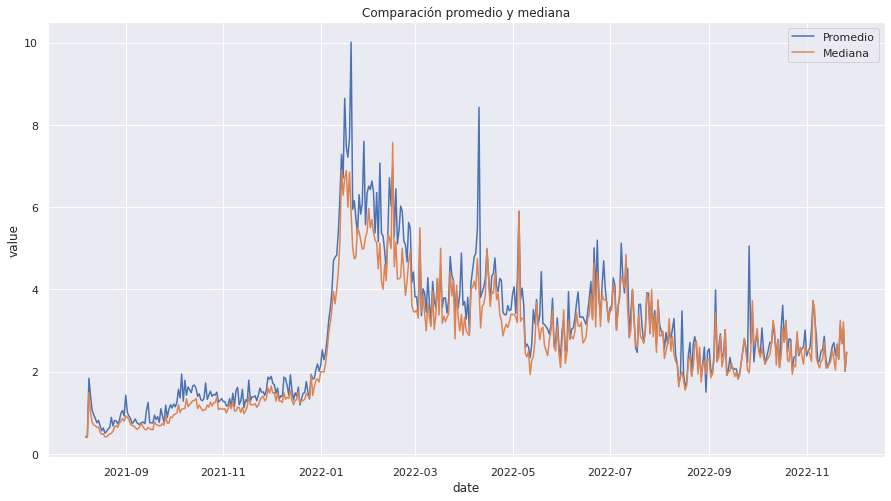

In [43]:
fig, ax = plt.subplots(figsize=[15,8])
sns.lineplot(x="date", y="Mean" ,data=df_stats,label="Promedio")
sns.lineplot(x="date", y="Median" ,data=df_stats,label="Mediana")
plt.title("Comparación promedio y mediana")
plt.ylabel("value")

Solo con la gráfica es observable que el promedio tiene mas picos, por lo que será mejor trabajar con la mediana como output.

### Aunque la mediana es menos ruidosa, vamos a suavizarla
Este proceso permite que la función sea más suave, es decir, que tenga menos picos, por ende es más “fácil” para la red neuronal aprender la función.


In [33]:
#compute smoothing_median 
len_data=df_stats.shape[0]
for indx in range(2,len_data):
    sum_median=df_stats.smoothing_median[indx-1]+df_stats.smoothing_median[indx-2]+df_stats.Median[indx]
    df_stats.smoothing_median[indx]=sum_median/3

<ipython-input-33-df1e567a052f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats.smoothing_median[indx]=sum_median/3


Text(0, 0.5, 'value')

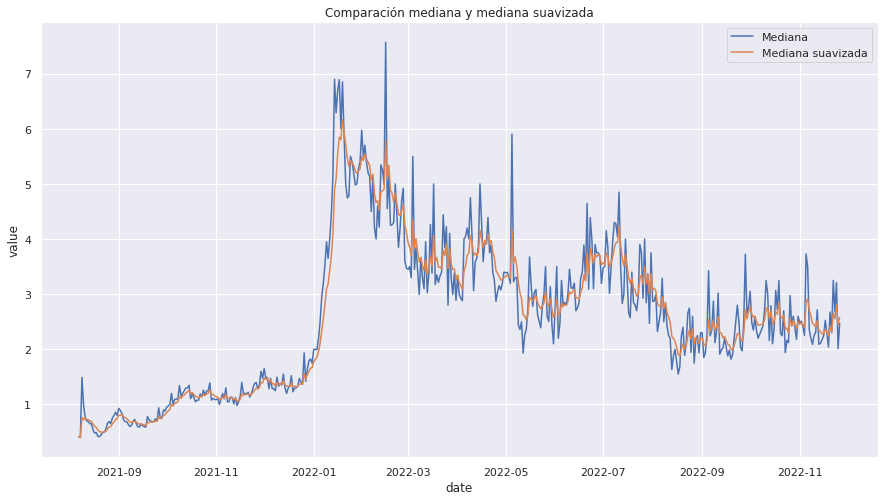

In [10]:
fig, ax = plt.subplots(figsize=[15,8])
sns.lineplot(x="date", y="Median" ,data=df_stats,label="Mediana")
sns.lineplot(x="date", y="smoothing_median" ,data=df_stats,label="Mediana suavizada")
plt.title("Comparación mediana y mediana suavizada")
plt.ylabel("value")

Una vez con la mediana suavizada ya tenemos cuatro inputs para pasarle a la red neuronal, el promedio, la mediana, la desviación y la mediana suavizada. Vamos a pasarle otro input llamada el retorno

### El retorno
El retorno significa en términos porcentuales que tanto más grande o pequeño es un valor respecto a otro con respecto a la mediana suavizada, por ejemplo si el valor de la mediana suavizada ayer era de 1.2 ETH y el de hoy es de 1.5, esto quiere decir que es un 25% mas grande, por lo que se le pasa ese día un retorno de 0.25.

In [11]:
#compute the return 
df_stats["return"]=(df_stats.smoothing_median.shift(1)/df_stats.smoothing_median)-1
df_stats["return"].fillna(0,inplace=True)

In [39]:
#the final dataFrame
df_stats.head()

,date,Mean,Median,st_deviation,smoothing_median,return
0,2021-08-07,0.415000,0.415,0.091924,0.415000,0.000000
1,2021-08-08,0.437841,0.400,0.345588,0.400000,0.037500
2,2021-08-09,1.840529,1.490,1.621085,0.768333,-0.479393
3,2021-08-10,1.409245,1.000,2.167395,0.722778,0.063028
4,2021-08-11,1.064520,0.770,1.230842,0.753704,-0.041032


---

## Modelo

Se construirá un modelo de redes neuronales LSTM que toma encuenta los datos del promedio, mediana, desviación,mediana suavizada y el retorno para predecir la mediana suavizada tomando un ventaneo de 5 dias,es decir se toman los registros de 5 días seguidos para predecir la mediana suavizada del siguiente.

Antes de construir el modelo, hay que estructurar nuestros datos:

### Normalización

teniendo encuenta que se usará una red neuronal LSTM, esta es sensible a la escala de los datos; es por eso que normalizamos nuestros datos a un rango [0,1] mediante el método Min-Max el cual consiste en lo siguiente:

$$x_{scalado}=\frac{x-x_\min}{x_\max-x_\min}$$

In [13]:
#objects to scale the data 
sc=MinMaxScaler()
sc2=MinMaxScaler()

In [14]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats.smoothing_median.values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["date"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


### Partición de los datos

Se realiza una partición de los datos, de tal manera que el 80% de los primeros registros sean para entrenamiento y el restante sea para probar el modelo. 

In [15]:
#last index of the train data
eight_percent=int(len_data*0.8)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

ahora hay que redimensionar nuestros datos para que nos quede con ventaneo de 5 dias, para el caso de entrenamiento al modelo se le pasan 371 datos , el primero de estos datos corresponde a un arreglo con el registro de los 5 primeros días, el segundo dato corresponde a un arreglo con los registros desde el día 2 hasta el día 6, y así sucesivamente, donde el último dato corresponde a un arreglo con los registros desde el día 371 hasta el día 376.


los datos de referencia y_train, se redimensionan de tal manera que nos quede el registro de la mediana suavizada apartir del día 6. 

In [16]:
#reshape train data
lag=5
len_df_train=df_train.shape[0]
X_train=[]
Y_train=[]
for i in range(lag,len_df_train):
    X_train.append(df_train[i-lag:i])
    Y_train.append(df_train_y_normalize[i])
    
X_train,Y_train=np.array(X_train),np.array(Y_train)
print(X_train.shape,Y_train.shape)

(371, 5, 5) (371, 1)


In [17]:
#reshape test data
len_df_test=df_test.shape[0]
X_test=[]
Y_test=[]
for i in range(lag,len_df_test):
    X_test.append(df_test[i-lag:i])
    Y_test.append(df_test_y_normalize[i])
    
X_test,Y_test=np.array(X_test),np.array(Y_test)
print(X_test.shape,Y_test.shape)

(89, 5, 5) (89, 1)


In [18]:
#reshape all data
len_df_all=df_data_normalize.shape[0]
X_all=[]
Y_all=[]
for i in range(lag,len_df_all):
    X_all.append(df_data_normalize[i-lag:i])
    Y_all.append(df_data_normalize[i])
    
X_all,Y_all=np.array(X_all),np.array(Y_all)
print(X_all.shape,Y_all.shape)

(465, 5, 5) (465, 5)


### Modelo

Se decidió realizar un modelo de red neuronal LSTM de una única capa con 64 neuronas, tomando de entrada un ventaneo de 5 días con los atributos de promedio, mediana, desviación estandar, mediana suavizada y retorno, y una capa de salida con una única neurona. Se utiliza el error cuadrático medio como función de perdida y un optimizador adamax.


In [19]:
#set the seed
random.set_seed(7)

#optional----
#callback to early stopping and prevent overfitting
#callback =callbacks.EarlyStopping(monitor='mae', patience=3)

#make the model
model=Sequential()
model.add(LSTM(units=64,return_sequences=False,input_shape=(5,5)))
model.add(Dense(1))
model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])

In [20]:
#fit the model with the train data
history=model.fit(X_train,Y_train,validation_split=0.2,epochs=100,batch_size=16)

Epoch 1/100
19/19 [==============================] - 3s 38ms/step - loss: 0.0914 - mae: 0.2259 - val_loss: 0.0051 - val_mae: 0.0579
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0224 - mae: 0.1276 - val_loss: 0.0027 - val_mae: 0.0404
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0103 - mae: 0.0883 - val_loss: 0.0030 - val_mae: 0.0448
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0046 - mae: 0.0585 - val_loss: 0.0022 - val_mae: 0.0381
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0027 - mae: 0.0410 - val_loss: 0.0024 - val_mae: 0.0392
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0023 - mae: 0.0352 - val_loss: 0.0025 - val_mae: 0.0399
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0023 - mae: 0.0334 - val_loss: 0.0026 - val_mae: 0.0407
Epoch 8/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0022 - 

Epoch 63/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0011 - mae: 0.0217 - val_loss: 9.8196e-04 - val_mae: 0.0242
Epoch 64/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0011 - mae: 0.0214 - val_loss: 9.5635e-04 - val_mae: 0.0245
Epoch 65/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0215 - val_loss: 9.4744e-04 - val_mae: 0.0240
Epoch 66/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0011 - mae: 0.0215 - val_loss: 9.6356e-04 - val_mae: 0.0249
Epoch 67/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0011 - mae: 0.0213 - val_loss: 9.4890e-04 - val_mae: 0.0239
Epoch 68/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0213 - val_loss: 9.3783e-04 - val_mae: 0.0238
Epoch 69/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0212 - val_loss: 9.2958e-04 - val_mae: 0.0238
Epoch 70/100
19/19 [============================

A continuación graficamos el comportamiento tanto del error cuadrático medio como del error absoluto medio, donde se observa que el error cae drásticamente en los primeros epochs y luego el error absoluto medio sigue decayendo pero en una proporción mucho menor.

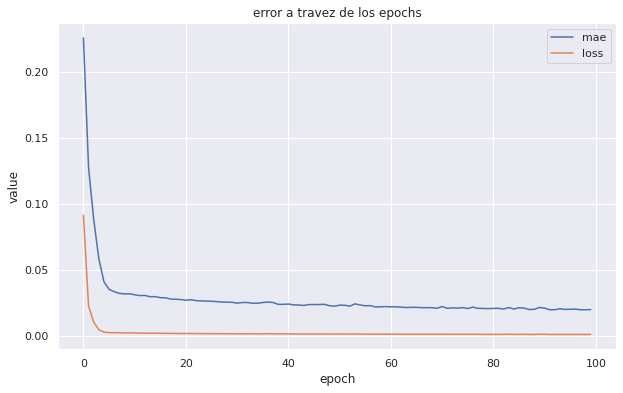

In [37]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.ylabel("value")
plt.xlabel("epoch")
plt.title("error a través de los epochs")
plt.legend()
plt.show()

### Resultado predicción datos de entrenamiento


In [22]:
# make predictions
trainPredict = model.predict(X_train)

# invert transformation
trainPredict = sc.inverse_transform(trainPredict)
trainY = df_train_y

12/12 [==============================] - 0s 2ms/step


Text(0, 0.5, 'value')

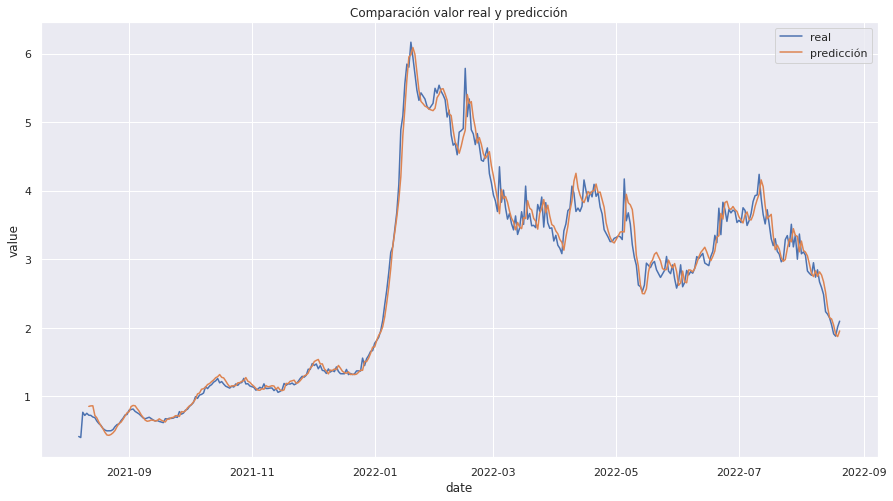

In [23]:
fig, ax = plt.subplots(figsize=[15,8])
sns.lineplot(x=df_stats["date"].iloc[:df_train_y.shape[0]],y=df_train_y.flatten(),label="real")
sns.lineplot(x=df_stats["date"].iloc[5:df_train_y.shape[0]],y=trainPredict.flatten(),label="predicción")
plt.title("Comparación valor real y predicción")
plt.ylabel("value")


### Resultado predicción datos de test


In [24]:
# make predictions
model.reset_states()
testPredict = model.predict(X_test)


# invert transformation
testPredict = sc.inverse_transform(testPredict)
testY = df_test_y

3/3 [==============================] - 0s 3ms/step


Text(0, 0.5, 'value')

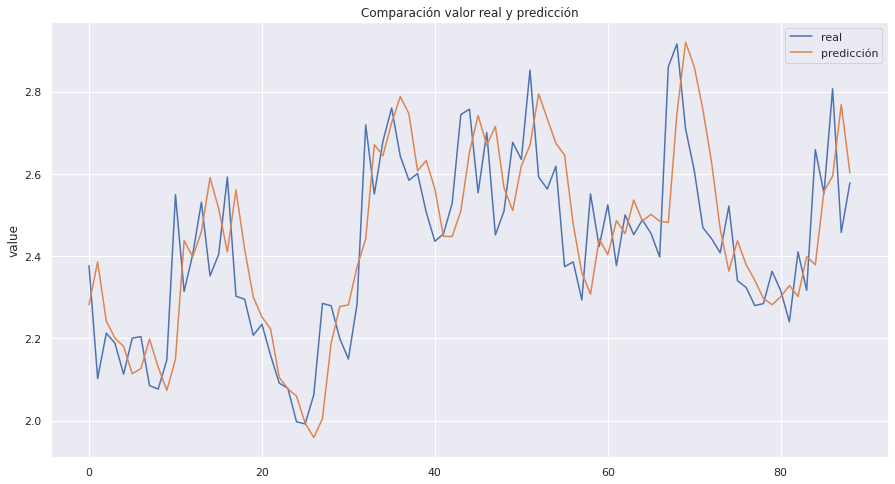

In [25]:
### Resultado predicción datos de entrenamiento
fig, ax = plt.subplots(figsize=[15,8])
sns.lineplot(df_test_y[5:].flatten(),label="real")
sns.lineplot(testPredict.flatten(),label="predicción")
plt.title("Comparación valor real y predicción")
plt.ylabel("value")

In [214]:
pd.DataFrame(testPredict.flatten())

,0
0,2.281611
1,2.385811
2,2.241953
3,2.200399
4,2.180234
...,...
84,2.378843
85,2.558191
86,2.594299
87,2.768816


### Resultado de la predicción completa

In [26]:
# make predictions
totalPredict = model.predict(X_all)

# invert transformation
allPredict = sc.inverse_transform(totalPredict)
allY = df_label

15/15 [==============================] - 0s 2ms/step


Text(0, 0.5, 'value')

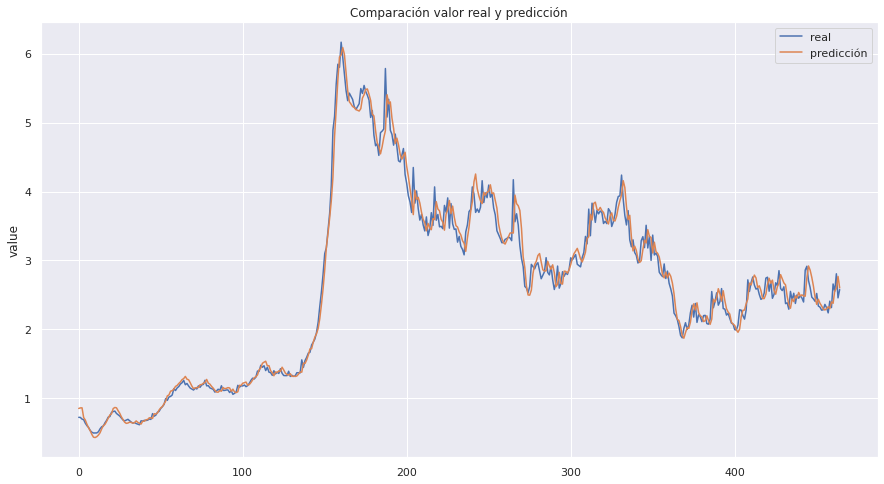

In [27]:
### Resultado predicción datos de entrenamiento
fig, ax = plt.subplots(figsize=[15,8])
sns.lineplot(allY[5:].flatten(),label="real")
sns.lineplot(allPredict.flatten(),label="predicción")
plt.title("Comparación valor real y predicción")
plt.ylabel("value")

### Evaluación del modelo

Para evaluar el modelo se hace uso de distintas métricas  como lo es MSE,MAE,RMSE,MAPE,$R^2$
\begin{eqnarray*}
    MSE &= \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i )^2 \\
    MAE &= \frac{1}{n} \sum_{i=1}^n \left| y_i - \hat{y}_i \right| \\
    RMSE &= \sqrt{ \frac{1}{n} \sum_{i=1}^n ( y_i - \hat{y}_i )^2 } \\
    MAPE &= 100\% \frac{1}{n} \sum_{i=1}^n \left|\frac{ y_i - \hat{y}_i}{y_i} \right|
\end{eqnarray*}
- MSE - error cuadrático medio
- MAE - error absoluto medio
- RMSE -raiz del error cuadrático medio
- MAPE - Error porcentual absoluto medio

In [28]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')

Primero se realiza la evaluación del modelo en los datos de entrenamiento obteniendo lo siguiente:

In [29]:
print("Train-metrics")
timeseries_evaluation_metrics_func(trainY.flatten()[5:], trainPredict.flatten(),False)

Train-metrics
Evaluation metric results:
MSE is : 0.029477318325522382
MAE is : 0.1177665547323263
RMSE is : 0.17168959876918108
MAPE is : 4.40451931700018


de manera general se obtiene un buen rendimiento del modelo para los datos de entrenamiento, teniendo encuenta la escala de los datos y los resultados del MSE,MAE y el RMSE, por otro lado el MAPE nos índica que en promedio el modelo aproxima el valor real con un 96% de precisión.

Ahora realizaremos la predicción con los datos de prueba para ver el comportamiento del modelo con datos que no ha visto con anterioridad y de esta manera saber si hubo overfitting además de ver su rendimiento

In [30]:
print("Test-metrics")
timeseries_evaluation_metrics_func(testY.flatten()[5:], testPredict.flatten(),False)

Test-metrics
Evaluation metric results:
MSE is : 0.022702307851018053
MAE is : 0.11864842035712256
RMSE is : 0.15067285041114092
MAPE is : 4.818758695500767


En este caso se obtuvieron resultados similares a los obtenidos con los datos de entrenamiento, lo cual es un buen indicio de que el modelo generalizó y no realizó overfitting, podemos observar la medida más intuitiva la cual es el MAPE nos indíca que el modelo aproxima en promedio el valor real con un 95% de precisión.

Por último se realizó la predicción completa de los datos y se calculó el $R^2$ del modelo

In [31]:
print("Total-metrics")
timeseries_evaluation_metrics_func(df_label[5:], allPredict.flatten(),True)

Total-metrics
R2 is : 0.9837074391731753



lo cual nos indica que nuestro modelo con las variables propuestas puede representar el 98% de la variabilidad de los datos.

---

## Referencias

[1] Russell, S. and Norvig, P. (2022) “Long short-term memory RNNs,” in
Artificial Intelligence: A modern approach. Harlow: Pearson Education
Limited